In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
# Load ECG dataset for anomaly detection
path = 'ecg.csv'
df = pd.read_csv(path, header=None)

# Drop any irrelevant columns if necessary (adjust if dataset structure varies)
df = df.drop(140, axis=1)  # Dropping 140th column as in the reference

# Preprocess data using StandardScaler
scaler = StandardScaler()
df = scaler.fit_transform(df)

# Split data into train and test sets
x_train, x_test = train_test_split(df, test_size=0.2)

In [5]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu')
])

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(8,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(x_train.shape[1], activation='linear')  # Linear for reconstruction
])

autoencoder = tf.keras.models.Sequential([encoder, decoder])

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.8558 - val_loss: 0.4315
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3930 - val_loss: 0.2994
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2854 - val_loss: 0.2645
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2476 - val_loss: 0.2473
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2336 - val_loss: 0.2333
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2200 - val_loss: 0.2271
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2159 - val_loss: 0.2171
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2041 - val_loss: 0.2065
Epoch 9/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1903 - val_loss: 0.1995
Epoch 10/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1823 - val_loss: 0.1934


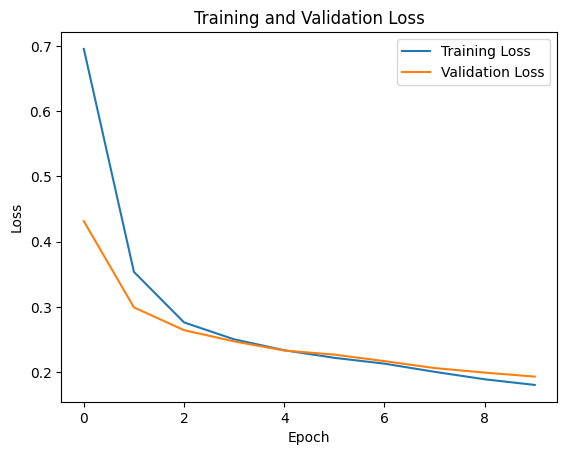

In [6]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

history = autoencoder.fit(
    x_train, 
    x_train, 
    validation_data=(x_test, x_test),
    epochs=10,
    batch_size=30,
    shuffle=True
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [7]:
predictions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - predictions, 2), axis=1)

# Define an anomaly detection threshold
threshold = np.percentile(mse, 95)  # Adjust percentile for sensitivity
anomalies = mse > threshold
num_anomalies = np.sum(anomalies)

print(f"Anomaly Detection Threshold: {threshold}")
print(f"Number of Anomalies Detected: {num_anomalies}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Anomaly Detection Threshold: 0.48298007966280876
Number of Anomalies Detected: 50


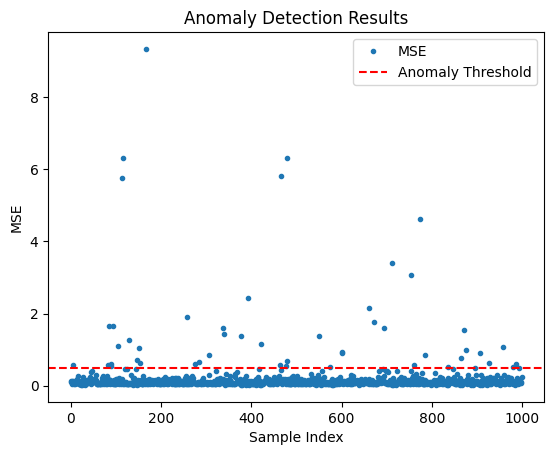

In [8]:
plt.plot(mse, marker='o', linestyle='', markersize=3, label='MSE')
plt.axhline(threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.xlabel('Sample Index')
plt.ylabel('MSE')
plt.title('Anomaly Detection Results')
plt.legend()
plt.show()

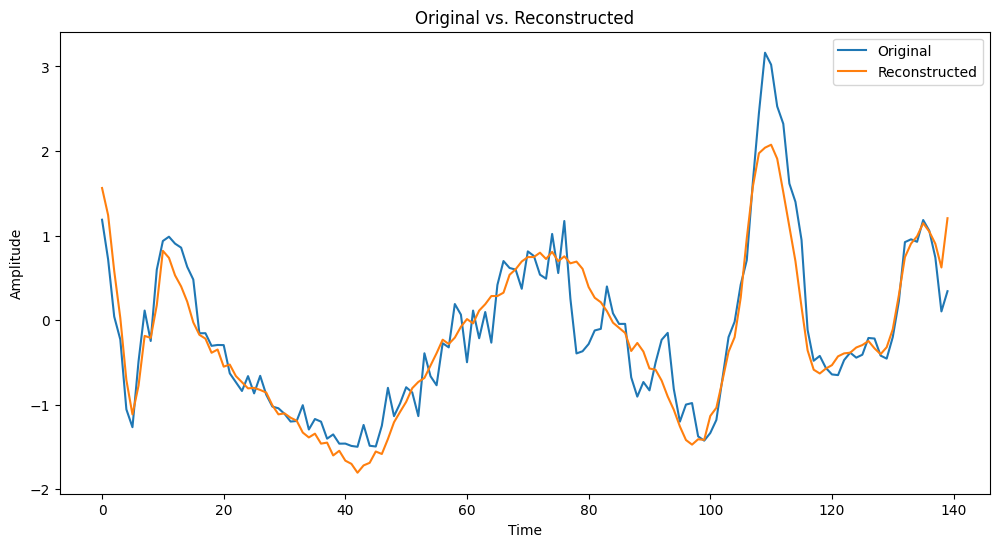

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(x_test[0], label='Original')
plt.plot(predictions[0], label='Reconstructed')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Original vs. Reconstructed')
plt.show()

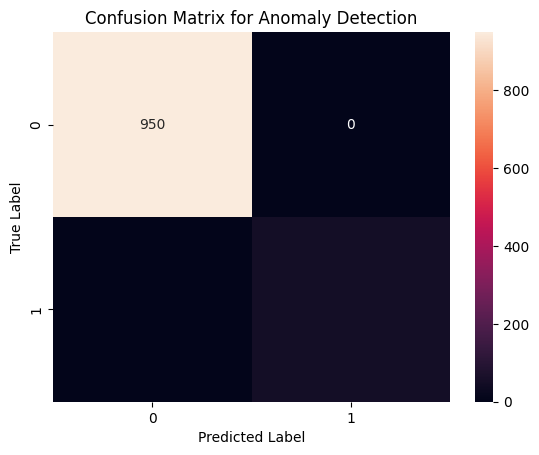

In [10]:
sns.heatmap(confusion_matrix(anomalies, anomalies), annot=True, fmt='d')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Anomaly Detection")
plt.show()